In [1]:
import os
import torch
from torch import nn, optim
from torch.nn import functional
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

In [2]:
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

In [30]:
batch_size = 256
data_set_root = 'datasets'

train_data = MNIST(data_set_root, train=True, transform=transforms.ToTensor(), download=True)
test_data = MNIST(data_set_root, train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

In [31]:
images, labels = next(iter(train_loader))
print("image: \n", images.shape)
print("label: ", labels.shape)

image: 
 torch.Size([256, 1, 28, 28])
label:  torch.Size([256])


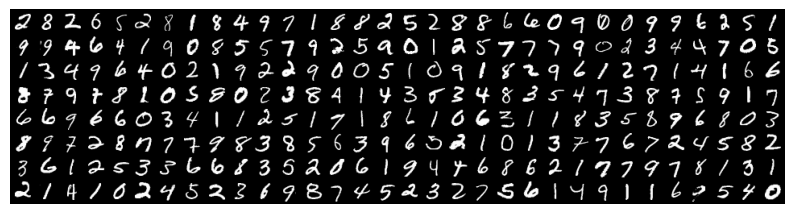

In [32]:
plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(images, 32)
plt.axis("off")
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
class MLP(nn.Module):
    def __init__(self, classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(785, 512)
        print(self.fc1.weight.shape) 
        self.fc2 = nn.Linear(512, 248)
        self.fc3 = nn.Linear(248, 128)
        self.fc4 = nn.Linear(128, classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        print(x.shape)
        x = functional.relu(self.fc1(x))
        x = functional.relu(self.fc2(x))
        x = functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [26]:
model = MLP(10).to(device=device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
epochs = 20
print(model)

torch.Size([512, 785])
MLP(
  (fc1): Linear(in_features=785, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=248, bias=True)
  (fc3): Linear(in_features=248, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [27]:
def train_epoch(model, train_loader, criterion, optimizer, loss_data):
    for index, (data, target) in enumerate(tqdm(train_loader, desc="Trainning", leave=False)):
        output = model(data.to(device))
        loss = criterion(output, target.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_data.append(loss.item())
    return model, optimizer, loss_data

In [28]:
def test_model(model, test_loader, criterion, loss_data):
    with torch.no_grad:
        correct_predictions = 0
        total_predictions = 0
        for index, (data, target) in enumerate(tqdm(test_loader, desc="Testing", leave=False)):
            output = model(data.to(device))
            _, predicted = torch.max(output, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target.to(device)).sum().item()
            loss = criterion(output, target.to(device))
            loss_data.append(loss.item())
        acc = (correct_predictions/total_predictions) * 100.0
        return acc, loss_data

In [29]:
train_loss = []
test_loss  = []
test_acc   = []
for index in trange(epochs, desc='epoch', leave=False):
    model, optimizer, train_loss = train_epoch(model=model, train_loader=train_loader, criterion=criterion, optimizer=optimizer, loss_data=train_loss)
    acc, test_loss = test_model(model=model, test_loader=test_loader, criterion=criterion, loss_data=test_loss)
    test_acc.append(acc)
print("Final Accuracy: %.2f%%" % acc)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Trainning:   0%|          | 0/235 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x784 and 785x512)